In [9]:
import pandas as pd

# File path
gct_file_path = 'C:/Users/Owner/Downloads/ML_Final_project/GTEx_Analysis_v10_RNASeQCv2.4.2_gene_tpm.gct/GTEx_Analysis_2022-06-06_v10_RNASeQCv2.4.2_gene_tpm_non_lcm.gct'

# Output file path
output_csv_path = 'C:/Users/Owner/Downloads/ML_Final_project/downsized_gene_expression_data_top_variance.csv'

# Define chunk size
chunk_size = 10000

# Initialize variables to store variance information across chunks
top_columns_variance = pd.Series(dtype='float64')  # To store variances of all columns
metadata = None  # Placeholder for metadata columns

# Process each chunk
for chunk in pd.read_csv(gct_file_path, sep='\t', skiprows=2, chunksize=chunk_size):
    # Separate metadata columns (the first two)
    metadata = chunk.iloc[:, :2] if metadata is None else metadata
    expression_columns = chunk.iloc[:, 2:]

    # Compute variance for each column in the current chunk
    chunk_variance = expression_columns.var()

    # Append variances to the global series
    top_columns_variance = pd.concat([top_columns_variance, chunk_variance])

# Selects the top 100 columns with the highest variance
top_columns = top_columns_variance.nlargest(100).index

# Process the dataset again to save only the selected columns
first_chunk = True
for chunk in pd.read_csv(gct_file_path, sep='\t', skiprows=2, chunksize=chunk_size):
    # Separate metadata columns
    metadata = chunk.iloc[:, :2]
    expression_columns = chunk.iloc[:, 2:]

    # Selects the top variance columns
    downsized_chunk = pd.concat([metadata, expression_columns[top_columns]], axis=1)

    # Append to output CSV
    downsized_chunk.to_csv(output_csv_path, mode='a', index=False, header=first_chunk)
    first_chunk = False  # Only write the header for the first chunk

print(f"\nDownsized data saved to: {output_csv_path}")



Downsized data saved to: C:/Users/Owner/Downloads/ML_Final_project/downsized_gene_expression_data_top_variance.csv


In [10]:
data_file = 'C:/Users/Owner/Downloads/ML_Final_project/downsized_gene_expression_data_top_variance.csv'

data = pd.read_csv(data_file)

print(data.shape)
print(data.info())

(59033, 102)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59033 entries, 0 to 59032
Columns: 102 entries, Name to GTEX-13QJC-0006-SM-HKZYR
dtypes: float64(100), object(2)
memory usage: 45.9+ MB
None


In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# File path for the downsized dataset
output_csv_path = 'C:/Users/Owner/Downloads/ML_Final_project/downsized_gene_expression_data_top_variance.csv'

# Read the downsized dataset
downsized_data = pd.read_csv(output_csv_path)

# Print the shape of the dataset
print("Shape of the downsized dataset:", downsized_data.shape)

# Get basic information about the dataset
print("\nDataset Info:")
print(downsized_data.info())

# Print the total size of the dataset
print("\nDataset Size (number of elements):", downsized_data.size)

# Check for missing values in each column
missing_values = downsized_data.isnull().sum()
print("\nMissing values in each column:")
print(missing_values[missing_values > 0])  # Display only columns with missing values

# Check if the entire dataset has any missing values
total_missing_values = missing_values.sum()
if total_missing_values > 0:
    print(f"\nTotal missing values in the dataset: {total_missing_values}")
else:
    print("\nNo missing values in the dataset.")

# Filter genes with low expression values (e.g., TPM < 1 in all samples)
metadata_columns = downsized_data.iloc[:, :2]  # First two columns are metadata
expression_columns = downsized_data.iloc[:, 2:]  # Remaining columns are expression data

data_filtered = downsized_data[(expression_columns > 1).sum(axis=1) > 0]
print("Shape after filtering low-expression genes:", data_filtered.shape)

# Save the filtered data before further processing
filtered_output_path = 'C:/Users/Owner/Downloads/ML_Final_project/filtered_gene_expression_data.csv'
data_filtered.to_csv(filtered_output_path, index=False)
print(f"\nFiltered data saved to: {filtered_output_path}")

# Normalize the filtered data (Standardization)
scaler = StandardScaler()
normalized_expression = scaler.fit_transform(data_filtered.iloc[:, 2:])

# Perform PCA to reduce dimensions
pca = PCA(n_components=10)  # Choose the number of principal components
pca_result = pca.fit_transform(normalized_expression)

# Combine metadata and PCA results
pca_columns = [f'PC{i+1}' for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_result, columns=pca_columns)
final_data = pd.concat([data_filtered.iloc[:, :2].reset_index(drop=True), pca_df], axis=1)

# Print explained variance ratio
print("\nExplained Variance Ratio by PCA Components:")
print(pca.explained_variance_ratio_)

# Save the final processed dataset to a new file
final_output_path = 'C:/Users/Owner/Downloads/ML_Final_project/final_gene_expression_data.csv'
final_data.to_csv(final_output_path, index=False)

print(f"\nFinal processed data saved to: {final_output_path}")


Shape of the downsized dataset: (59033, 102)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59033 entries, 0 to 59032
Columns: 102 entries, Name to GTEX-13QJC-0006-SM-HKZYR
dtypes: float64(100), object(2)
memory usage: 45.9+ MB
None

Dataset Size (number of elements): 6021366

Missing values in each column:
Series([], dtype: int64)

No missing values in the dataset.
Shape after filtering low-expression genes: (22394, 102)

Filtered data saved to: C:/Users/Owner/Downloads/ML_Final_project/filtered_gene_expression_data.csv

Explained Variance Ratio by PCA Components:
[9.81820464e-01 1.00001841e-02 6.42604125e-03 1.08057095e-03
 3.18827928e-04 1.27916988e-04 4.06540856e-05 3.46467875e-05
 2.32450880e-05 1.84187050e-05]

Final processed data saved to: C:/Users/Owner/Downloads/ML_Final_project/final_gene_expression_data.csv



Exploring Filtered Data:
Shape of Filtered Data: (22394, 102)

Filtered Data Description:
       GTEX-1RLM8-0005-SM-DO121  GTEX-1192X-0005-SM-5NQC3  \
count              22394.000000              22394.000000   
mean                  44.647720                 44.647816   
std                 4931.615988               4662.286233   
min                    0.000000                  0.000000   
25%                    0.031862                  0.027015   
50%                    0.226503                  0.245001   
75%                    1.028303                  1.219772   
max               724375.000000             676571.000000   

       GTEX-1117F-0005-SM-HL9SH  GTEX-145MG-0005-SM-HK78V  \
count              22394.000000              22394.000000   
mean                  44.645161                 44.645978   
std                 4589.121540               4518.411542   
min                    0.000000                  0.000000   
25%                    0.051795                  0.034

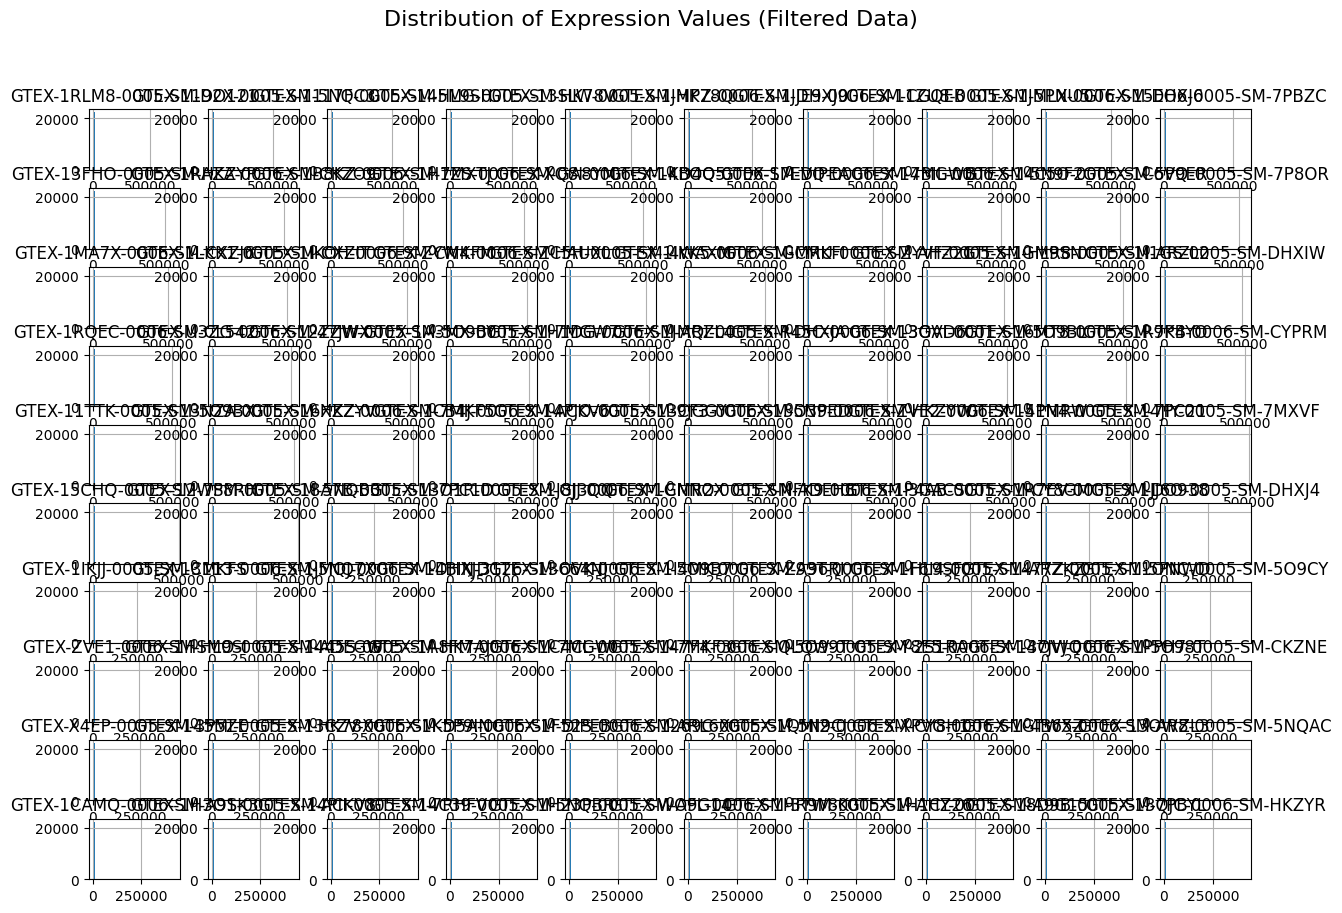

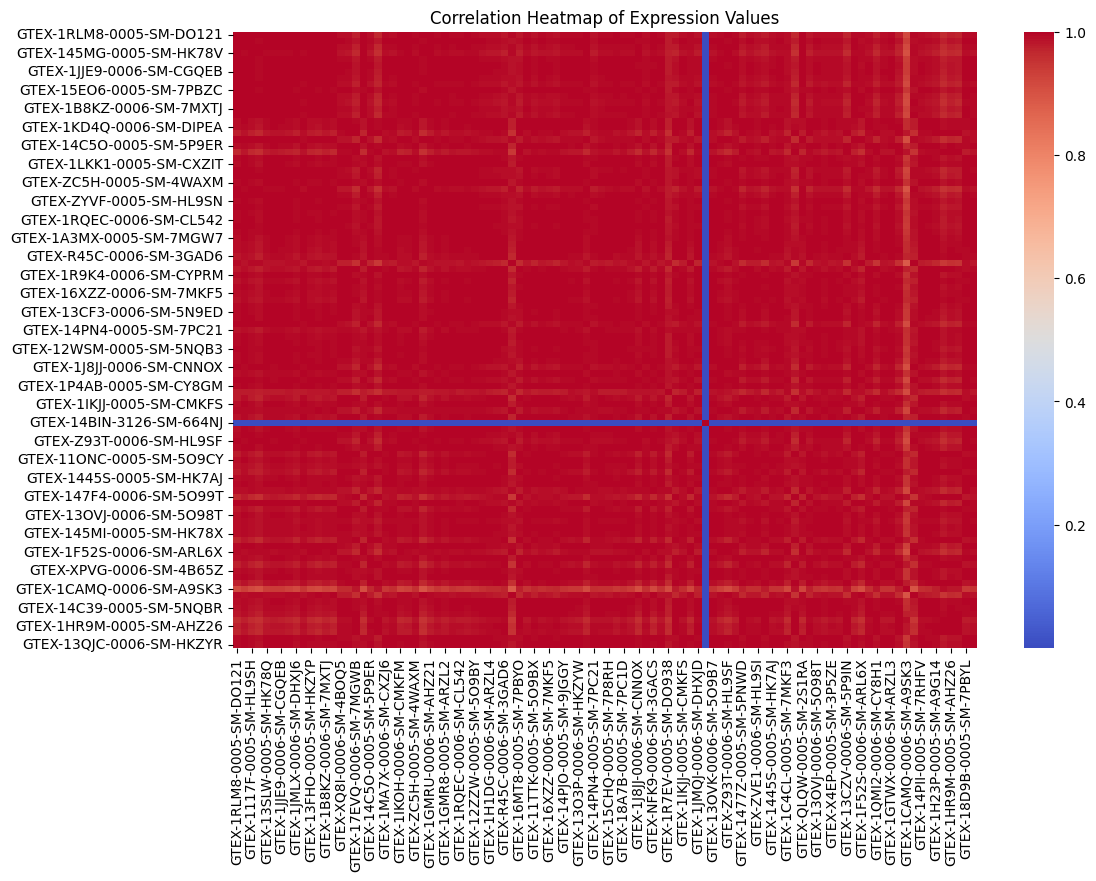


Exploring PCA-Transformed Data:
Shape of PCA Data: (22394, 12)

PCA Data Description:
                PC1           PC2           PC3           PC4           PC5  \
count  2.239400e+04  2.239400e+04  2.239400e+04  2.239400e+04  2.239400e+04   
mean   3.553666e-17  3.791634e-17  5.116327e-17  4.136689e-17  3.379155e-17   
std    9.908907e+00  1.000032e+00  8.016438e-01  3.287277e-01  1.785615e-01   
min   -1.285031e-01 -1.917134e-01 -3.350058e+01 -9.243555e+00 -2.507853e+01   
25%   -1.279884e-01 -1.400821e-02 -3.445378e-03 -9.151170e-03 -1.455805e-03   
50%   -1.260599e-01 -1.287086e-02 -2.686249e-03 -8.978833e-03 -1.290328e-03   
75%   -1.162417e-01 -9.559955e-03 -2.543559e-03 -7.612705e-03 -5.706805e-04   
max    1.419677e+03  1.488378e+02  1.127121e+02  4.573093e+01  4.091815e+00   

                PC6           PC7           PC8           PC9          PC10  
count  2.239400e+04  2.239400e+04  2.239400e+04  2.239400e+04  2.239400e+04  
mean   3.775770e-17  3.664718e-17 -3.331561e-

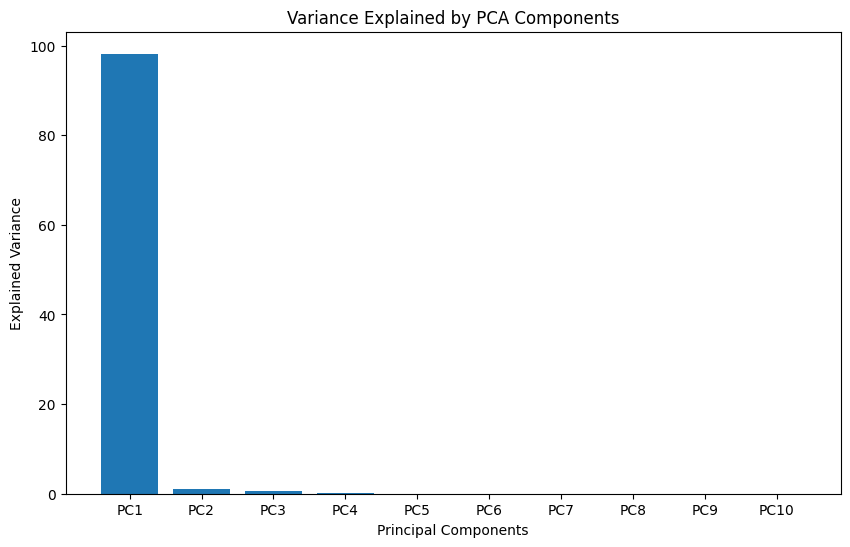

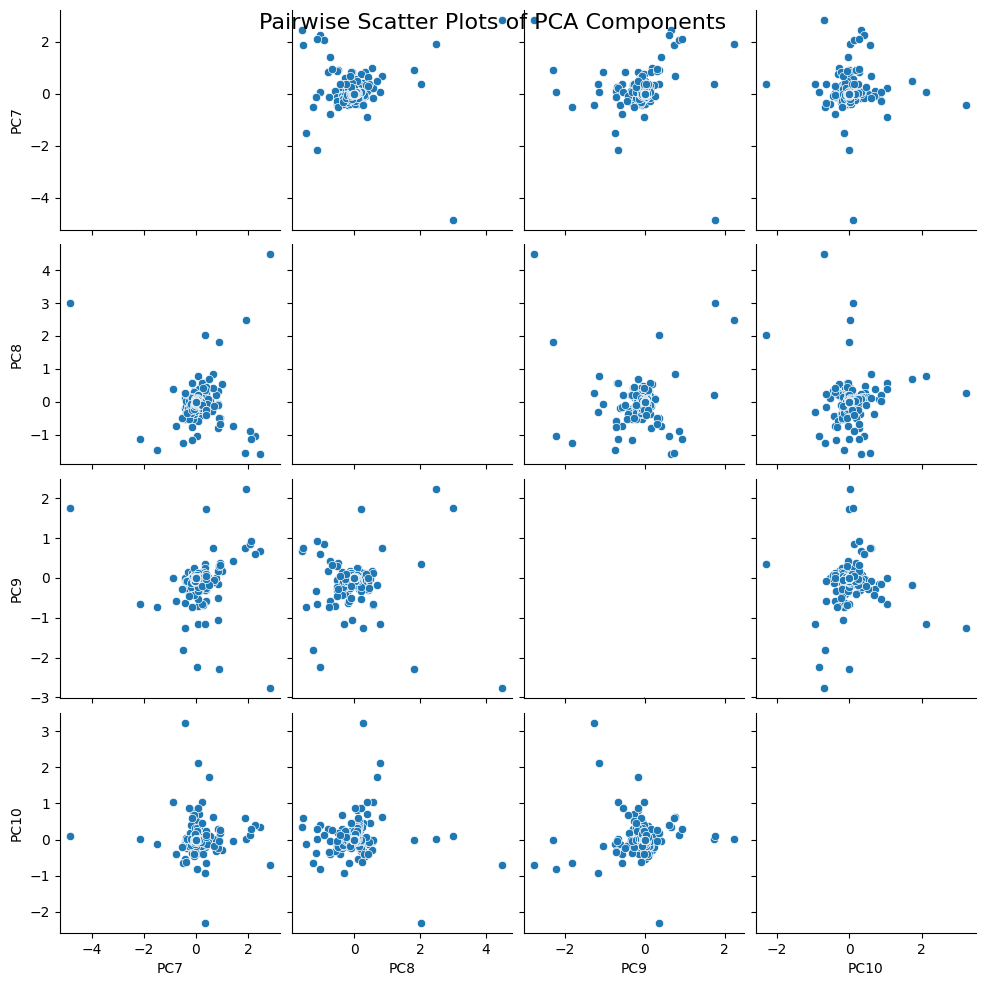

C:\Users\Owner\AppData\Local\Temp\ipykernel_7300\971533820.py:69: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(pca_data['PC1'], pca_data['PC2'], alpha=0.6, cmap='viridis')


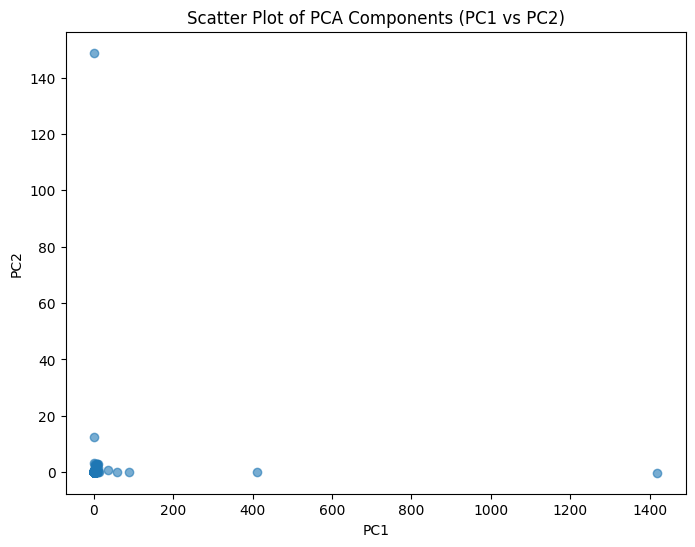

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# File paths
filtered_output_path = 'C:/Users/Owner/Downloads/ML_Final_project/filtered_gene_expression_data.csv'
final_output_path = 'C:/Users/Owner/Downloads/ML_Final_project/final_gene_expression_data.csv'

# Load the filtered data
filtered_data = pd.read_csv(filtered_output_path)

# Load the final PCA-transformed data
pca_data = pd.read_csv(final_output_path)

# Explore Filtered Data
print("\nExploring Filtered Data:")

# Shape and summary statistics
print("Shape of Filtered Data:", filtered_data.shape)
print("\nFiltered Data Description:")
print(filtered_data.describe())

# Check for missing values
missing_values_filtered = filtered_data.isnull().sum()
print("\nMissing values in filtered data:")
print(missing_values_filtered[missing_values_filtered > 0])

# Visualize data distribution for a sample of expression columns
expression_columns = filtered_data.columns[2:]  # first two columns are metadata
filtered_data[expression_columns].hist(bins=30, figsize=(15, 10))
plt.suptitle("Distribution of Expression Values (Filtered Data)", fontsize=16)
plt.show()

# Correlation heatmap of expression data
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_data[expression_columns].corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap of Expression Values")
plt.show()

# Explore PCA Data
print("\nExploring PCA-Transformed Data:")

# Shape and summary statistics
print("Shape of PCA Data:", pca_data.shape)
print("\nPCA Data Description:")
print(pca_data.describe())

# Plot explained variance ratio (from PCA components)
pca_variance = pca_data.columns[-10:]  # last 10 columns are PCA components
explained_variance = pca_variance  # Replacing with PCA variance ratios if available
plt.figure(figsize=(10, 6))
plt.bar(pca_variance, pca_data[explained_variance].var())
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance")
plt.title("Variance Explained by PCA Components")
plt.show()

# Pairwise scatter plots of the first 4 PCA components
sns.pairplot(pca_data.iloc[:, -4:])
plt.suptitle("Pairwise Scatter Plots of PCA Components", fontsize=16)
plt.show()

# 2D Scatter plot of the first two PCA components
plt.figure(figsize=(8, 6))
plt.scatter(pca_data['PC1'], pca_data['PC2'], alpha=0.6, cmap='viridis')
plt.title("Scatter Plot of PCA Components (PC1 vs PC2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
